# Heart Predict Prediction
- A classification problem to predict whether someone has heart attack
- [Source Data](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/code?sort=votes)

# Importing Libraries

In [134]:
import os
import pickle
import numpy as np 
import pandas as pd
import seaborn as sns 
import scipy.stats as ss
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import \
    train_test_split, GridSearchCV
from sklearn.preprocessing import \
    LabelEncoder, MinMaxScaler, StandardScaler

from sklearn.linear_model import \
    LogisticRegression, LinearRegression

from sklearn.ensemble import \
    RandomForestClassifier, GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC ,SVR

from sklearn.metrics import \
    f1_score, confusion_matrix, accuracy_score, classification_report

from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
#Cramers Function
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [ ]:
# constants 
## clean path!
CSV_PATH = os.path.join(os.getcwd(),'heart.csv')
BEST_ESTIMATOR_SAVE_PATH=os.path.join(os.getcwd(),'best_estimator.pkl')

In [ ]:
def plot_con_graph(con_col,df,c):
  '''
  This function is meant to plot continuos data using seaborn distplot function

  Parameters
  ----------
  con : LIST
      con_col contains the name of the categorical columns.
  df : DATAFRAME
      DESCRIPTION
  c : str
      String that sets the colour of the plot

  Returns
  -------
  None.
  '''

  for i in con_col:
    plt.figure()
    sns.distplot(df[i],color='c')
    plt.show()

# 1) Data Loading

In [ ]:
# constants
# from google.colab import drive
# drive.mount('/content/drive')

df = pd.read_csv(CSV_PATH)


In [ ]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


Notes:
set:
caa : 4 = null
thal : 0 = null

In [ ]:
df.nunique()

age          41
sex           2
cp            4
trtbps       49
chol        152
fbs           2
restecg       3
thalachh     91
exng          2
oldpeak      40
slp           3
caa           5
thall         4
output        2
dtype: int64

In [ ]:
#checking for missing values
df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Obervation:

1. Age is measured in days, we might wanna convert that to year for eda, and check/drop cvd babies?
2. bmi can be added since obesity is (highly) corelated to CVD

# 2) Data Vizualization

In [ ]:
con = ['age','trtbps','chol','thalachh','oldpeak']
cat = df.drop(labels=con, axis=1).columns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


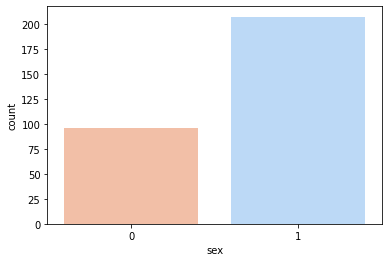

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


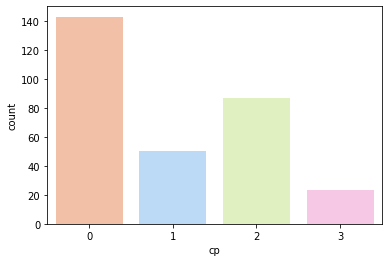

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


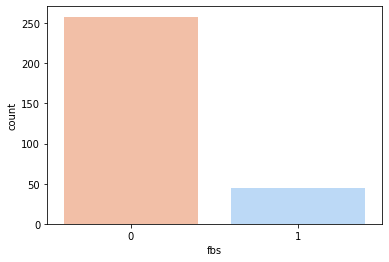

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


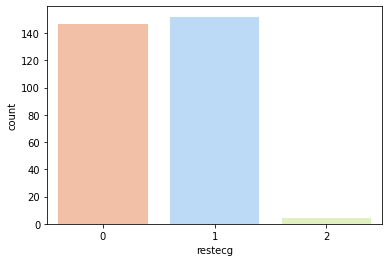

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


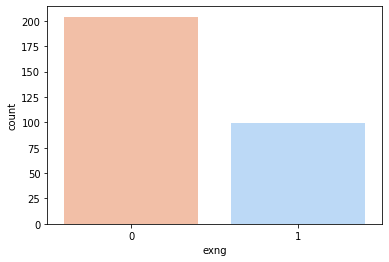

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


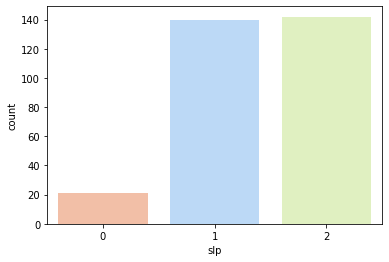

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


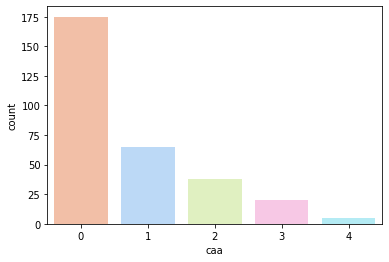

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


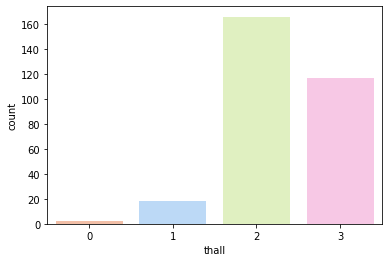

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


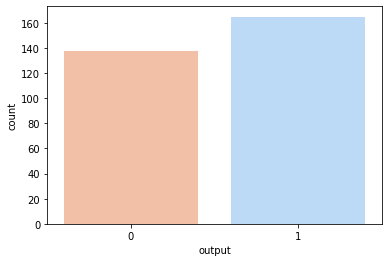

In [ ]:
custom = ['#FEBB9A','#B3D9FF', '#E3F8B9','#FFC0E7','#A9F3FF','#DFD8D1']

for i in cat:
  plt.figure()
  sns.countplot(df[i], palette= custom) 
  plt.show()


Notes:
slightly imbalance dataset, but acceptable

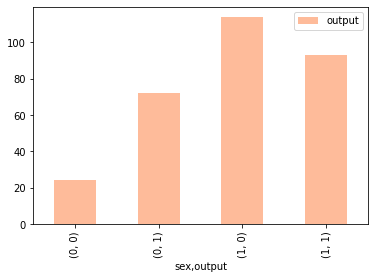

In [ ]:
df.groupby(['sex','output']).agg({'output':'count'}).plot(kind='bar',color= '#FEBB9A')
# df.groupby(['sex','alco']).agg({'alco':'count'}).plot(kind='bar',color= '#E3F8B9')
# df.groupby(['sex','smoke']).agg({'smoke':'count'}).plot(kind='bar',color= '#FFC0E7')
# df.groupby(['sex','active']).agg({'active':'count'}).plot(kind='bar',color= '#A9F3FF')



In [ ]:
# 1: Male 0:Female

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


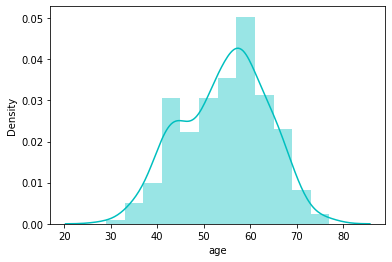

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


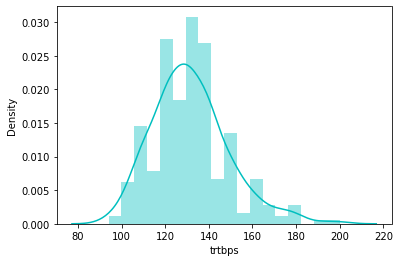

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


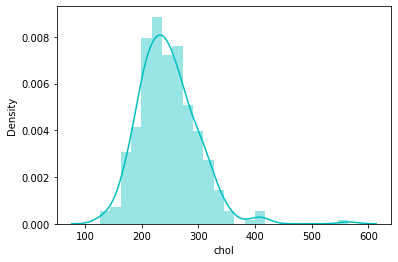

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


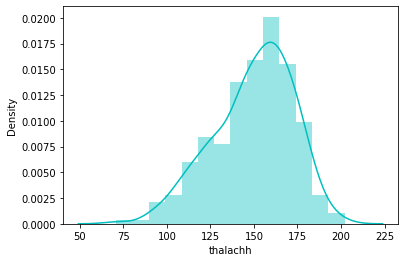

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


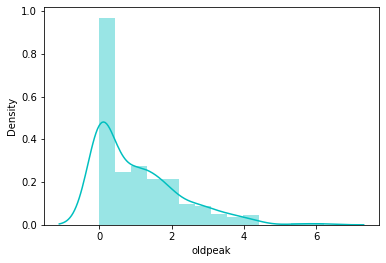

In [ ]:
plot_con_graph(con,df,'c')


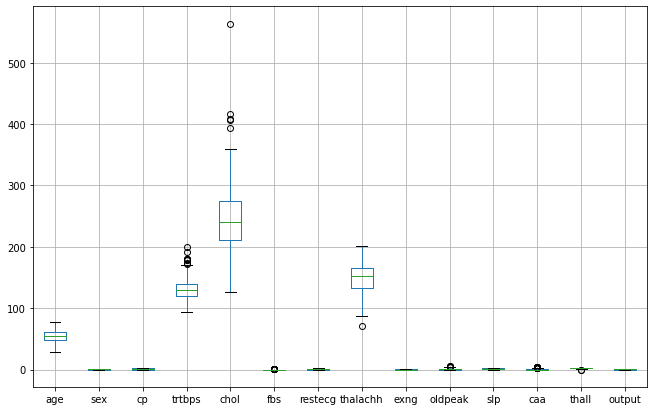

In [ ]:
df.boxplot(figsize=(11,7))

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


Observation:
1. age range focuses on 29-77 
2. thall & caa hahave some hidden null data
3. one outlier in chol

# 3) Data Cleaning
1. Outliers
2. Missing Values
3. Duplicated

## 3.1 Dealing with Outliers
1. Clip the only outliers from chol col

In [ ]:
#METHOD 2: clipping the outliers
#clipping data with realistic blood pressures
df['chol'] = df['chol'].clip(126,430)

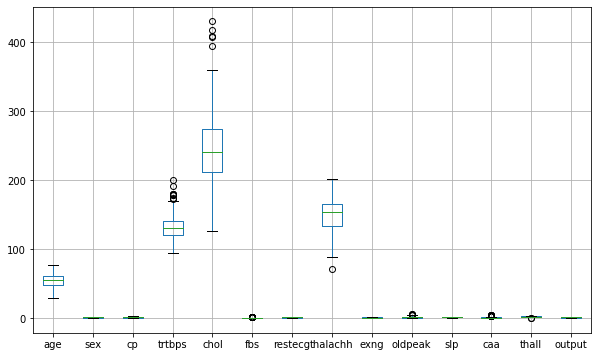

In [ ]:
df.boxplot(figsize=(10,6))
#outliers are now treated

## 3.2 Dealing with Missing Values


In [ ]:
#querying the data with invalid input

df.query('thall == 0 or caa == 4')

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
48,53,0,2,128,216,0,0,115,0,0.0,2,0,0,1
92,52,1,2,138,223,0,1,169,0,0.0,2,4,2,1
158,58,1,1,125,220,0,1,144,0,0.4,1,4,3,1
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
251,43,1,0,132,247,1,0,143,1,0.1,1,4,3,0
281,52,1,0,128,204,1,1,156,1,1.0,1,0,0,0


We have 7 data with positive outputs.
Since we have a really small datasets, we might want to make fill the datasets by the output. 
- to improve the performance
- drop it for the first round

In [ ]:
df.drop(df.query('thall == 0 or caa == 4').index,axis=0,inplace=True)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,296.0,54.523649,9.059471,29.0,48.0,56.0,61.00,77.0
sex,296.0,0.679054,0.467631,0.0,0.0,1.0,1.00,1.0
cp,296.0,0.959459,1.034184,0.0,0.0,1.0,2.00,3.0
trtbps,296.0,131.604730,17.726620,94.0,120.0,130.0,140.00,200.0
chol,296.0,246.702703,49.743608,126.0,211.0,242.5,275.25,430.0
fbs,296.0,0.145270,0.352970,0.0,0.0,0.0,0.00,1.0
restecg,296.0,0.523649,0.526692,0.0,0.0,1.0,1.00,2.0
thalachh,296.0,149.560811,22.970792,71.0,133.0,152.5,166.00,202.0
exng,296.0,0.327703,0.470171,0.0,0.0,0.0,1.00,1.0
oldpeak,296.0,1.059122,1.166474,0.0,0.0,0.8,1.65,6.2


In [ ]:


# df.boxplot()

# for i in con:
#   df[i] = df[i].fillna(df[i].median())

# for i in cat:
#   df[i] = df[i].fillna(df[i].mode()[0])

# df.isna().sum()


##3.3 Droping Duplicates

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe().T
#clean datasets of 296 entries

,count,mean,std,min,25%,50%,75%,max
age,296.0,54.523649,9.059471,29.0,48.0,56.0,61.00,77.0
sex,296.0,0.679054,0.467631,0.0,0.0,1.0,1.00,1.0
cp,296.0,0.959459,1.034184,0.0,0.0,1.0,2.00,3.0
trtbps,296.0,131.604730,17.726620,94.0,120.0,130.0,140.00,200.0
chol,296.0,246.702703,49.743608,126.0,211.0,242.5,275.25,430.0
fbs,296.0,0.145270,0.352970,0.0,0.0,0.0,0.00,1.0
restecg,296.0,0.523649,0.526692,0.0,0.0,1.0,1.00,2.0
thalachh,296.0,149.560811,22.970792,71.0,133.0,152.5,166.00,202.0
exng,296.0,0.327703,0.470171,0.0,0.0,0.0,1.00,1.0
oldpeak,296.0,1.059122,1.166474,0.0,0.0,0.8,1.65,6.2


# 4) Features Selection

In [ ]:
#cat = df[cat].drop(labels='output', axis=1).columns

In [ ]:
for i in cat:
    print(i)
    matrix = pd.crosstab(df[i],df['output']).to_numpy()
    print(cramers_corrected_stat(matrix))

#only cholesterol has correlation with CVD

for i in con:
    print(i)
    lr=LogisticRegression()
    lr.fit(np.expand_dims(df[i],axis=-1),df['output'])
    print(lr.score(np.expand_dims(df[i],axis=-1),df['output']))


sex
0.2723595387818863
cp
0.4989641008565132
fbs
0.0
restecg
0.156829365591162
exng
0.4144909577107241
slp
0.3797704515657343
caa
0.4884654999890648
thall
0.5264498919776031
age
0.6216216216216216
trtbps
0.5777027027027027
chol
0.5371621621621622
thalachh
0.706081081081081
oldpeak
0.6858108108108109


In [ ]:
#checking why fbs output = 0
display(df.groupby('fbs')['fbs'].size())

fbs
0    258
1     45
Name: fbs, dtype: int64

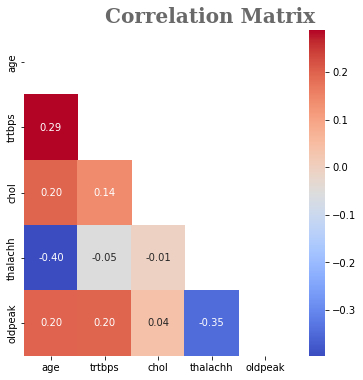

In [170]:
fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])

df_corr = df[con].corr().transpose()

mask = np.triu(np.ones_like(df_corr))
ax0.text(1.5,-0.1,"Correlation Matrix",fontsize=20, fontweight='bold', fontfamily='serif', color="#696969")
df_corr = df[con].corr().transpose()
sns.heatmap(df_corr,mask=mask,fmt=".2f",annot=True,cmap='coolwarm')
plt.show()

# 5) Pre-processing

In [147]:
#select features that has the highest coleration
X = df.drop(['output'],axis=1)
y = df['output']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=413)

# 6) Model Development

In [148]:
#Pipeline to find the best model
#Logistic Regression
pipeline_mms_lr = Pipeline([
                           ('Min_Max_Scaler', MinMaxScaler()),
                           ('Logistic_Classifier', LogisticRegression())
                           ]) # Pipeline([STEPS])


pipeline_ss_lr = Pipeline([
                           ('Standard_Scaler',StandardScaler()), 
                           ('Logistic_Classifier', LogisticRegression())
                           ]) 

#Random Forest
pipeline_mms_dt = Pipeline([
                           ('Min_Max_Scaler', MinMaxScaler()),
                           ('Decision_Tree_Classifier', DecisionTreeClassifier())
                           ]) 


pipeline_ss_dt = Pipeline([
                           ('Standard_Scaler',StandardScaler()), 
                           ('Decision_Tree_Classifier', DecisionTreeClassifier())
                           ]) 

#SVC
pipeline_mms_svc = Pipeline([
                            ('Min_Max_Scaler', MinMaxScaler()),
                            ('SVC_Classifier', SVC())
                            ]) 


pipeline_ss_svc = Pipeline([
                            ('Standard_Scaler', StandardScaler()),
                            ('SVC_Classifier', SVC())
                            ])
#gradient boost
pipeline_mms_gb = Pipeline([
                            ('Min_Max_Scaler',MinMaxScaler()),
                            ('GBoost_Classifier', GradientBoostingClassifier())
                            ])

pipeline_ss_gb = Pipeline([
                            ('Min_Max_Scaler',StandardScaler()),
                            ('GBoost_Classifier', GradientBoostingClassifier())
                            ])


#storing pipelines in a list
pipelines = [pipeline_mms_lr, pipeline_ss_lr,
             pipeline_mms_dt, pipeline_ss_dt, 
             pipeline_mms_svc, pipeline_ss_svc,
             pipeline_mms_gb, pipeline_ss_gb]

#fitting of data
for pipe in pipelines:
    pipe.fit(X_train, y_train)

#create a list that store model name for reporting table, to be looped and parsed as keys
model_name = ['MMS+Logistic Regression', 'SS+Logistic Regression', 
              'MMS+Decision Tree', 'SS+Decision Tree',
              'MMS+SVC','SS+SVC',
              'MMS+Gradient Boost','SS+Gradient Boost',
              ]

#dictionary to store evaluation matrics of all the pipelines
pipe_dict =  {}

best_score = 0

#model evaluation
for i, model in enumerate(pipelines):   
    y_pred = model.predict(X_test)

    pipe_dict[model_name[i]] = [accuracy_score(y_test,y_pred),
                    f1_score(y_test,y_pred, average='weighted')]

    if model.score(X_test, y_test) > best_score:
        best_score = model.score(X_test, y_test)
        best_pipeline = model_name[i]

print('The best scaling approach for Cardiovascular Disease Prediction is {} with the accuracy of {}'.
      format(best_pipeline,best_score))


The best scaling approach for Cardiovascular Disease Prediction is SS+Logistic Regression with the accuracy of 0.8426966292134831


In [140]:
print(pipe_dict)
#print(pipe_dict.keys(2)) duh! can't access key by index

{'MMS+Logistic Regression': [0.8314606741573034, 0.8315884038472181], 'SS+Logistic Regression': [0.8426966292134831, 0.842776075360345], 'MMS+Decision Tree': [0.7303370786516854, 0.7305415753058928], 'SS+Decision Tree': [0.6629213483146067, 0.6630915900578822], 'MMS+SVC': [0.8089887640449438, 0.8086509899760576], 'SS+SVC': [0.8089887640449438, 0.8086509899760576], 'MMS+Gradient Boost': [0.8089887640449438, 0.8086509899760576], 'SS+Gradient Boost': [0.8089887640449438, 0.8086509899760576]}


# Model Comparison Table

In [149]:
#model comparison tables
model_comparison_df = pd.DataFrame.from_dict(pipe_dict).T
model_comparison_df.columns = ['Accuracy', 'F1 Score']
model_comparison_df = model_comparison_df.sort_values('F1 Score', ascending=False)
model_comparison_df.style.background_gradient(cmap='coolwarm')
#model_comparison_df.sort_values(by='F1 Score',ascending=False).style.highlight_max()

,Accuracy,F1 Score
SS+Logistic Regression,0.842697,0.842816
MMS+Logistic Regression,0.808989,0.809134
MMS+SVC,0.808989,0.808989
MMS+Gradient Boost,0.808989,0.808651
SS+Gradient Boost,0.808989,0.808651
SS+SVC,0.775281,0.775451
SS+Decision Tree,0.707865,0.708087
MMS+Decision Tree,0.707865,0.706979



### Gridsearch cv



In [151]:
from sklearn.model_selection import GridSearchCV
#brute force to try out all combinations
pipeline_ss_lr = Pipeline([
                           ('Standard_Scaler',StandardScaler()), 
                           ('Logistic_Classifier', LogisticRegression())
                           ]) 

In [152]:
pipeline_ss_lr.get_params().keys()
#printing all hyperparameters for reference

dict_keys(['memory', 'steps', 'verbose', 'Standard_Scaler', 'Logistic_Classifier', 'Standard_Scaler__copy', 'Standard_Scaler__with_mean', 'Standard_Scaler__with_std', 'Logistic_Classifier__C', 'Logistic_Classifier__class_weight', 'Logistic_Classifier__dual', 'Logistic_Classifier__fit_intercept', 'Logistic_Classifier__intercept_scaling', 'Logistic_Classifier__l1_ratio', 'Logistic_Classifier__max_iter', 'Logistic_Classifier__multi_class', 'Logistic_Classifier__n_jobs', 'Logistic_Classifier__penalty', 'Logistic_Classifier__random_state', 'Logistic_Classifier__solver', 'Logistic_Classifier__tol', 'Logistic_Classifier__verbose', 'Logistic_Classifier__warm_start'])

In [155]:
grid_param = [{'Logistic_Classifier__C':[1.0,1.5,2.5],
               'Logistic_Classifier__class_weight':[None,'balanced'],
               'Logistic_Classifier__max_iter':[100,500,1000],
               'Logistic_Classifier__random_state':[1,3,4],
               'Logistic_Classifier__solver':['lbfgs','liblinear','sag']
             }]

grid_search = GridSearchCV(pipeline_ss_lr, grid_param, 
                                 cv=5, verbose=1, n_jobs=-1)

grid = grid_search.fit(X_train, y_train)
print(grid_search.score(X_test,y_test))
display(grid.best_params_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
0.8426966292134831


{'Logistic_Classifier__C': 1.0,
 'Logistic_Classifier__class_weight': None,
 'Logistic_Classifier__max_iter': 100,
 'Logistic_Classifier__random_state': 1,
 'Logistic_Classifier__solver': 'lbfgs'}

In [156]:
#Model Evaluation
y_pred = grid.predict(X_test)
y_true = y_test

labels = ['No Heart Attack','Heart Attack']
cm = confusion_matrix(y_true,y_pred)
cr = classification_report(y_true,y_pred, target_names = labels)

In [157]:
print(cr)

                 precision    recall  f1-score   support

No Heart Attack       0.87      0.83      0.85        47
   Heart Attack       0.82      0.86      0.84        42

       accuracy                           0.84        89
      macro avg       0.84      0.84      0.84        89
   weighted avg       0.84      0.84      0.84        89



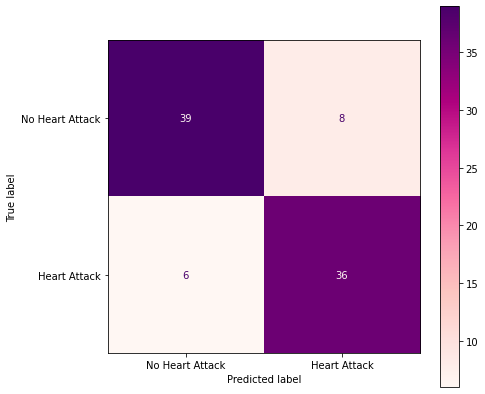

<function classification_report at 0x7f80c76d7cb0>


In [158]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels =labels)
disp.plot(cmap='RdPu')
plt.rcParams['figure.figsize'] = [7, 7]
plt.show()

print(classification_report)

In [160]:
#saving the best model
BEST_ESTIMATOR_SAVE_PATH= os.path.join(os.getcwd(),'best_estimator.pkl')

with open(BEST_ESTIMATOR_SAVE_PATH, 'wb') as file:
    pickle.dump(grid.best_estimator_,file)

**Zip and download from Colab**

In [163]:
!zip -r /content/heart.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.07.13/ (stored 0%)
  adding: content/.config/logs/2022.07.13/13.42.32.441281.log (deflated 54%)
  adding: content/.config/logs/2022.07.13/13.42.53.106562.log (deflated 54%)
  adding: content/.config/logs/2022.07.13/13.42.25.014838.log (deflated 86%)
  adding: content/.config/logs/2022.07.13/13.42.53.841315.log (deflated 54%)
  adding: content/.config/logs/2022.07.13/13.41.43.930690.log (deflated 91%)
  adding: content/.config/logs/2022.07.13/13.42.05.105178.log (deflated 54%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/conf

In [166]:
from google.colab import files
files.download("/content/heart.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7 Streamlit

Writing app.py file


In [ ]:
%%writefile app.py

import os
import pickle
import numpy as np
import streamlit as st
import pandas as pd


#%% deployment
MODEL_PATH = os.path.join(os.getcwd(),'best_estimator.pkl')

with open(MODEL_PATH,'rb') as file:
    model = pickle.load(file)

# Cholesterol 1,2,3
# ap_hi : 
# ap_lo
# new_data = [cholesterol,ap_hi,ap_lo]
# new_data = np.expand_dims([2,200,110],axis=0)
# outcome = model.predict(new_data)[0]


with st.form("Heart Attack Predictor App"):
    chol = st.selectbox('Cholesterol Level: 1: normal, 2: above normal, 3: well above normal', (1,2,3))
    sys = st.number_input('Systolic BP')
    dia = st.number_input('Diastolic BP')

    # Every form must have a submit button.
    submitted = st.form_submit_button("Submit")
    if submitted:
        new_data = np.expand_dims([chol,sys,dia],axis=0)
        outcome = model.predict(new_data)[0]
        
        if outcome == 0:
            st.write('Congrats you are healthy, keep it up')
            st.balloons()
        else:
            st.write('Start Exercising now!!!')
            st.snow()



Overwriting app.py
